In [1]:
# 표준 라이브러리
import os
import requests
from IPython.display import Image, display
# 서드파티 라이브러리
import streamlit as st
import openai
from dotenv import load_dotenv
import json
from typing import List, Annotated, Literal, Dict, Callable, TypeVar, Tuple, Type, Generic, Optional, Union, Any
from typing_extensions import TypedDict  # TypedDict를 typing_extensions에서 import



# LangChain 및 LangGraph 관련 라이브러리
from langchain_openai import OpenAI
from langchain_groq import ChatGroq
from langchain.prompts import PromptTemplate
from langchain.prompts.chat import ChatPromptTemplate, MessagesPlaceholder
from langchain.chains import LLMChain
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.language_models.chat_models import BaseChatModel
from langchain.agents import AgentExecutor
from langchain_community.agent_toolkits.polygon.toolkit import PolygonToolkit
from langchain_community.utilities.polygon import PolygonAPIWrapper
from langchain.tools import tool

from langgraph.types import Command
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import create_react_agent
from langchain_community.tools.tavily_search import TavilySearchResults
from langsmith import utils 
from agents.agent_library import agent_configs, AgentConfig
from datetime import datetime, timedelta
from dateutil.parser import parse
import yfinance as yf
import pandas as pd
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate

from typing_extensions import TypedDict

from langgraph.graph import MessagesState, END
from langgraph.types import Command
from sec_tool.sec_insider_trade_field_definitions import SEC_Insider_Trade_NecessaryFields
from sec_tool.sec_financial_fiedls_definitions import FinancialNecessaryFields
from sec_tool.insider_trade_tool import SECInsiderTradeAPI
from sec_tool.market_data_tool import MarketDataTools, FinancialDataTools


In [2]:
# 환경 변수 로드
load_dotenv()
print(utils.tracing_is_enabled())

MODEL_NAME = "gemma2-9b-it"

True


In [3]:
class AgentState(MessagesState):
    query: str
    context: list
    answer: str

In [4]:
SEC_API_KEY = os.getenv("SEC_API_KEY")

small_llm = ChatGroq(
    model=MODEL_NAME,
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18")

In [5]:

# 시장 조사 에이전트
market_research_agent = create_react_agent(
    llm, 
    tools=MarketDataTools.get_polygon_tools(), 
    state_modifier='You are a market researcher. Provide fact only not opinions'
)

def market_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    시장 조사 node. 주어진 state를 기반으로 시장 조사 에이전트를 호출하고,
    결과를 supervisor node로 전달

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환
    """
    # 시장 조사 에이전트를 호출하여 결과를 얻습니다.
    result = market_research_agent.invoke(state)
    
    # 결과 메시지를 업데이트하고 supervisor node로 이동합니다.
    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='market_research')]},
        goto='supervisor'
    )



In [6]:
stock_research_tools = [MarketDataTools.get_stock_price]
stock_research_agent = create_react_agent(
    llm, tools=stock_research_tools, state_modifier='You are a stock researcher. Provide facts only not opinions'
)


def stock_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    주식 조사 node
    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환
    """
    result = stock_research_agent.invoke(state)

    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='stock_research')]},
        goto='supervisor'
    )




In [7]:
# 도구 리스트
company_research_tools = [FinancialDataTools.get_income_statement, FinancialDataTools.get_financial_event_filings]

# 단일 에이전트 정의
company_research_agent = create_react_agent(
    llm,
    tools=company_research_tools,
    state_modifier='You are a company researcher. Provide facts only, no opinions. Use get_income_statement for income statement data and get_financial_event_filings for key financial and event-related SEC filings.'
)

def financial_reports_and_events_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    회사 재무 보고서와 주요 사건 관련 자료를 조사하는 노드.
    손익계산서 데이터와 재무 및 주요 사건 관련 SEC 보고서를 처리합니다.

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor 노드로 이동하기 위한 명령을 반환
    """
    result = company_research_agent.invoke(state)
    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='financial_reports_and_events')]},
        goto='supervisor'
    )


In [8]:
analyst_prompt = PromptTemplate.from_template(
    """You are a stock market analyst. Given the following information, 
Please decide wheter to buy, sell, or hold the stock.

Information:
{messages}"""
)

analyst_chain = analyst_prompt | llm

def analyst_node(state: MessagesState):
    """
    분석가 node

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        dict: 분석 결과 메시지를 포함하는 딕셔너리를 반환
    """
    result = analyst_chain.invoke({'messages': state['messages'][1:]})

    return {'messages': [result]}

In [9]:

current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

insider_tracker_system_prompt = f"""You are an insider trading analyst.
You must provide factual data only, without any personal opinions or speculations.
The current time is {current_time}. Use this time when invoking tools that require the current time as an argument."""


insider_tracker_research_tools = [SECInsiderTradeAPI.fetch_filings]
insider_tracker_research_agent = create_react_agent(
    llm, tools=insider_tracker_research_tools, prompt=insider_tracker_system_prompt
)



def insider_tracker_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    내부자 거래 내역 조사 node 
    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환
    """
    result = insider_tracker_research_agent.invoke(state)

    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='insider_tracker_research')]},
        goto='supervisor'
    )



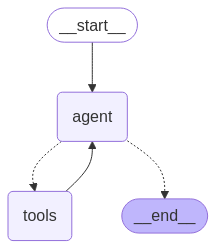

In [10]:
insider_tracker_research_agent

In [11]:
members = ["market_research", "stock_research", "financial_reports_and_events","insider_tracker_research"]
options_for_next = members + ["FINISH"]


# system_prompt = (
#     "You are a supervisor tasked with managing a conversation between the following workers: "
#     f"{members}. Given the following user request, respond with the worker to act next. "
#     "Each worker will perform a task and respond with their results and status. "
#     "When finished, respond with FINISH."
# )
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

# ChatPromptTemplate 생성
supervisor_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next? "
            "Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options_for_next), members=", ".join(members))


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options_for_next]



def supervisor_node(state: MessagesState) -> Command[Literal[*members, "analyst"]]:
    """
    supervisor node 
    주어진 State를 기반으로 각 worker의 결과를 종합하고,
    다음에 수행할 worker를 결정
    모든 작업이 완료되면 analyst node로 이동

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: 다음에 수행할 worker 또는 analyst node로 이동하기 위한 명령 반환 
    """

    supervisor_chain = supervisor_prompt | llm.with_structured_output(Router)
    response= supervisor_chain.invoke(state)

    goto = response["next"]
    if goto == "FINISH":
        goto = "analyst"

    return Command(goto=goto)

In [12]:
graph_builder = StateGraph(MessagesState)

graph_builder.add_node("supervisor", supervisor_node)
graph_builder.add_node("market_research", market_research_node)
graph_builder.add_node("stock_research", stock_research_node)
graph_builder.add_node("financial_reports_and_events", financial_reports_and_events_node)
graph_builder.add_node("insider_tracker_research", insider_tracker_research_node)
graph_builder.add_node("analyst", analyst_node)

graph_builder.add_edge(START, "supervisor")
graph_builder.add_edge("analyst", END)
graph = graph_builder.compile()



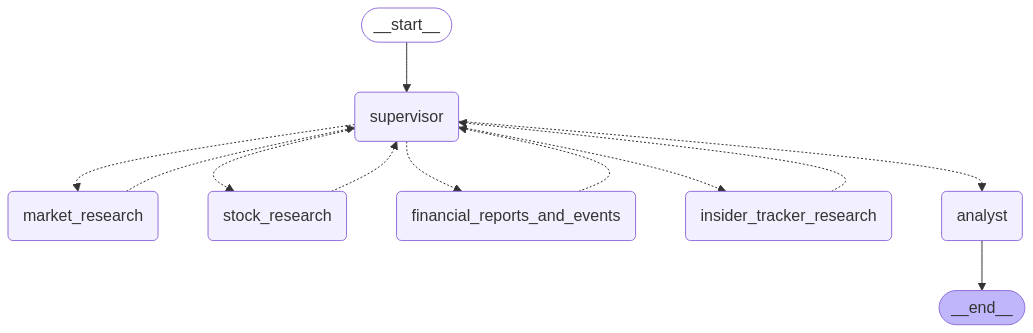

In [13]:
graph

In [14]:
for chunk in graph.stream(
    {"messages": [("user", "최근 한달간 테슬라 내부자 거래가 있었는지 확인해줘")]}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

최근 한달간 테슬라 내부자 거래가 있었는지 확인해줘
200
================================ Human Message =================================
Name: insider_tracker_research

최근 한 달간(2025년 2월 18일부터 2025년 3월 18일까지) 테슬라(TSLA) 내부자 거래 내역은 다음과 같습니다:

1. **James R. Murdoch (이사)**
   - **거래 일자:** 2025-03-10
     - **매수:** 180,000주, 주당 가격 $23.85
     - **매수:** 351,787주, 주당 가격 $24.73
     - **매도:** 54,776주, 주당 가격 범위 $240.650 - $241.050(가중 평균 가격 $240.788)
     - **팔로온 후 소유주식:** 477,011주
   - **파생상품 거래:**
     - **비죄 같은 옵션:** 180,000주, 행사가격 $23.85 (만료일: 2025-06-14)
     - **비죄 같은 옵션:** 351,787주, 행사가격 $24.73 (만료일: 2025-06-18)

2. **Vaibhav Taneja (CFO)**
   - **거래 일자:** 2025-03-05
     - **매수:** 6,538주 (가격 미제공)
     - **매도:** 2,672.25주, 주당 가격 $268.729
   - **파생상품 거래:**
     - **제한 주식 단위:** 6,538주

3. **Vaibhav Taneja (CFO)**
   - **거래 일자:** 2025-03-03
     - **매수:** 6,000주, 주당 가격 $18.22
     - **매도:** 다양한 주식의 판매 (총 6,000주 이상 거래)
   - **パ라데미 상품 거

In [13]:
for chunk in graph.stream(
    {"messages": [("user", "24년 1월에 테슬라를 매도한 내부자가 있나?")]}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

24년 1월에 테슬라를 매도한 내부자가 있나?
200
================================ Human Message =================================
Name: insider_tracker_research

2024년 1월에 테슬라(TSLA)를 매도한 내부자는 없었습니다. SEC 제출 기록에 따르면 해당 기간 동안 TSLA에 대한 내부자 거래가 없습니다.
================================== Ai Message ==================================

Based on the provided information that there were no insider sales of Tesla (TSLA) in January 2024 and that SEC filings indicate no insider trading during that period, it suggests that insiders are not selling their shares. This can be interpreted as a positive signal, indicating that those with inside knowledge of the company’s operations and future prospects are confident enough to hold onto their shares, rather than cashing out.

Given this information, the recommendation would be to **hold** the stock for now. Holding might be the appropriate strategy since there are currently no negative signals f

In [14]:
for chunk in graph.stream(
    {"messages": [("user", "오늘 테슬라 주가가 얼마냐")]}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

오늘 테슬라 주가가 얼마냐
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


================================ Human Message =================================
Name: stock_research

오늘 테슬라(TSLA)의 주가는 다음과 같습니다:

- 종가: $238.01
- 최고가: $245.40
- 최저가: $232.80
- 시가: $245.06
- 거래량: 111,379,700 주
================================== Ai Message ==================================

Based on the information provided about Tesla's (TSLA) stock for today:

- **Closing Price**: $238.01
- **Day's High**: $245.40
- **Day's Low**: $232.80
- **Opening Price**: $245.06
- **Trading Volume**: 111,379,700 shares

### Analysis:

1. **Price Movement**: The stock opened at $245.06 and closed at $238.01, indicating a price decline throughout the day. The drop from the opening price to the closing price suggests weakness in demand.

2. **Range of Trading**: The stock's high for the day was $245.40 and the low was $232.80. This range shows that there was some volatility, but ultimately, the stock closed significantly lower than it opened.

3. **Volume**: The trading volume is quite high at 111

In [15]:
for chunk in graph.stream(
    {"messages": [("user", "최근 한달간 테슬라 평균 종가 가격은 얼마냐?")]}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

최근 한달간 테슬라 평균 종가 가격은 얼마냐?


[*********************100%***********************]  1 of 1 completed


================================ Human Message =================================
Name: stock_research

최근 한 달간 테슬라(TSLA)의 종가 데이터는 다음과 같습니다:

- 2025-02-18: 354.11
- 2025-02-19: 360.56
- 2025-02-20: 354.40
- 2025-02-21: 337.80
- 2025-02-24: 330.53
- 2025-02-25: 302.80
- 2025-02-26: 290.80
- 2025-02-27: 281.95
- 2025-02-28: 292.98
- 2025-03-03: 284.65
- 2025-03-04: 272.04
- 2025-03-05: 279.10
- 2025-03-06: 263.45
- 2025-03-07: 262.67
- 2025-03-10: 222.15
- 2025-03-11: 230.58
- 2025-03-12: 248.09
- 2025-03-13: 240.68
- 2025-03-14: 249.98
- 2025-03-17: 238.01

이 데이터를 바탕으로, 지난 한 달간의 평균 종가는 약 270.34입니다.
================================== Ai Message ==================================

Based on the provided data for Tesla (TSLA) over the past month, we observe a downward trend in the stock price. Here are some key points from the data:

1. **Price Decline**: The stock has decreased significantly from a high of around $360.56 on February 19 to a low of $222.15 on March 10, indicating a consisten